# pip & import

In [212]:
# pip보다 작업을 더욱 쉽게 만들어줌
!pip install micropip

In [213]:
# Matplotlib 기반, 벤 다이어그램을 그리는 데 사용
# 집합, 그룹 간의 관계를 시각화
!pip install matplotlib-venn

In [214]:
import micropip
await micropip.install("seaborn")

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # 시각화 폰트를 적용

fe = fm.FontEntry(fname = 'MaruBuri-Regular.otf', name = 'MaruBuri')
fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='MaruBuri')

In [215]:
import os # 시스템
import random # 난수생성
import numpy as np # 행렬연산
import pandas as pd # 데이터 분석

In [216]:
# matplotlib 캐시 삭제
!rm -rf ~/.cache/matplotlib

In [217]:
# font 다운로드
!sudo apt-get install fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [218]:
# 글꼴 캐시 업데이트 및 추가
!sudo fc-cache -fv

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm
plt.rc('font', family='NanumBarunGothic')
sns.set(font="NanumBarunGothic",
        rc={"axes.unicode_minus":False},
        style='darkgrid')
plt.rcParams['font.family'] = 'NanumBarunGothic'

In [220]:
plt.rc('font', family='NanumBarunGothic')
# 한글 폰트 사용 시 마이너스 폰트 깨짐 방지
plt.rc('axes', unicode_minus=False)

# seed 고정 & 함수정의

In [221]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# Data Load

In [222]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount("/content/data")

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [223]:
# 딕셔너리를 간편하게 사용하는 것을 도와준다. 모델 class 처럼 사용 가능
# dot을 이용해 객체를 불러 사용. JSON 다룰때 유용.
import easydict
args = easydict.EasyDict()

# path
args.default_path = "/content/data/MyDrive/Playdata/Competitions/ML/DG/Data/" # 메인 경로
args.train_path = args.default_path + "train.csv" # train 데이터 경로
args.test_path = args.default_path + "test.csv" # train 데이터 경로

args.default_submission_path = args.default_path + "sample_submission.csv" # 예측결과(제출파일) 경로
args.result_path = "/content/data/MyDrive/Playdata/Competitions/ML/DG/Result/"

# 데이터 분석을 위한 변수들
# 난수 생성 제어 => 같은 코드를 실행해도 동일한 결과를 얻기 위해서 설정
# 데이터 분할 및 모델 초기화 때 유용.
args.random_state = 42
args.results = [] # 결과 저장 리스트

In [224]:
# Data를 불러와 DataFrame화
train_org = pd.read_csv(args.train_path)
test_org = pd.read_csv(args.test_path)

In [225]:
# 원본데이터 보존을 위해 복사를 해서 분석에 사용
train_df = train_org.copy()
test_df = test_org.copy()

In [226]:
# 대구광역시 중구 대신동 => 대구광역시 / 중구 / 대신동 => 각 컬럼 생성
train_df['시'] = train_df['시군구'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else '')
train_df['군'] = train_df['시군구'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else '')
train_df['구'] = train_df['시군구'].apply(lambda x: x.split()[2] if len(x.split()) > 2 else '')

In [227]:
a = train_df['시군구'].head(1)
b = train_df['시'].head(1)
c = train_df['군'].head(1)
d = train_df['구'].head(1)

a, b, c, d

(0    대구광역시 중구 대신동
 Name: 시군구, dtype: object,
 0    대구광역시
 Name: 시, dtype: object,
 0    중구
 Name: 군, dtype: object,
 0    대신동
 Name: 구, dtype: object)

# EDA

## train, test 기간확인

In [228]:
display(f"train : {train_org.iloc[0]['사고일시']} ~ {train_org.iloc[-1]['사고일시']}")
display(f"test : {test_org.iloc[0]['사고일시']} ~ {test_org.iloc[-1]['사고일시']}")

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

# 데이터 전처리

## 날짜, 시간정보 생성

In [229]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

# C# : Regex
train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '시', '군', '구', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

## 위치 정보 생성

In [230]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
# train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
# test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '시', '군', '구', '연', '월', '일', '시간', '도시', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간',\n       '도시', '구', '동'],\n      dtype='object')"

## 도로형태 정보 추출
ex) '단일로 - 기타'
- 도로형태1 : 단일로
- 도로형태2 : 기타

In [231]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '시', '군', '구', '연', '월', '일', '시간', '도시', '동', '도로형태1',\n       '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

## 추가 및 확인

In [232]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   요일           39609 non-null  object
 2   기상상태         39609 non-null  object
 3   시군구          39609 non-null  object
 4   노면상태         39609 non-null  object
 5   사고유형         39609 non-null  object
 6   사고유형 - 세부분류  39609 non-null  object
 7   법규위반         39609 non-null  object
 8   가해운전자 차종     39609 non-null  object
 9   가해운전자 성별     39609 non-null  object
 10  가해운전자 연령     39609 non-null  object
 11  가해운전자 상해정도   39609 non-null  object
 12  피해운전자 차종     38618 non-null  object
 13  피해운전자 성별     38618 non-null  object
 14  피해운전자 연령     38618 non-null  object
 15  피해운전자 상해정도   38618 non-null  object
 16  사망자수         39609 non-null  int64 
 17  중상자수         39609 non-null  int64 
 18  경상자수         39609 non-null  int64 
 19  부상자수         39609 non-nu

In [240]:
train_df[["군", "구", "동"]].head()

,군,구,동
0,중구,중구,대신동
1,달서구,달서구,감삼동
2,수성구,수성구,두산동
3,북구,북구,복현동
4,동구,동구,신암동


In [233]:
accident_counts = train_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']

# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옵니다.
train_df['사고발생횟수'] = train_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])

# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옵니다.
test_df['사고발생횟수'] = test_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])

train_df = train_df.drop(columns=['시군구'])
test_df = test_df.drop(columns=['시군구'])

In [234]:
train_eda_df = train_df.copy()

In [235]:
# '노면상태'와 '기상상태' 별 사고 발생 건수
accidents_count = train_eda_df.groupby(['노면상태', '기상상태']).size().reset_index(name='사고건수')

# '노면상태'와 '기상상태' 별 전체 사고 건수
total_accidents = train_eda_df.groupby(['노면상태', '기상상태']).size().sum()

# 상대적인 발생 비율을 구합니다.
accidents_count['상대적 발생 비율'] = accidents_count['사고건수'] / total_accidents

display(accidents_count)

,노면상태,기상상태,사고건수,상대적 발생 비율
0,건조,기타,50,0.001262
1,건조,맑음,35951,0.907647
2,건조,흐림,419,0.010578
3,기타,기타,3,0.000076
4,기타,맑음,41,0.001035
5,기타,비,6,0.000151
6,기타,안개,2,0.000050
7,기타,흐림,6,0.000151
8,서리/결빙,눈,1,0.000025
9,서리/결빙,맑음,18,0.000454


In [236]:
train_eda_df['요일'].value_counts()

금요일    6179
화요일    6023
수요일    5969
월요일    5895
목요일    5759
토요일    5670
일요일    4114
Name: 요일, dtype: int64

In [237]:
train_eda_df['주말여부'] = train_eda_df['요일'].apply(lambda x: '주말' if x in ["토요일", "일요일"] else '평일')

# 시간대 별로 구분. 0-6시, 6-12시, 12-18시, 18-24시=
bins = [0, 6, 12, 18, 24]
labels = ['새벽', '오전', '오후', '저녁']
train_eda_df['시간대'] = pd.cut(train_eda_df['시간'], bins=bins, labels=labels, include_lowest=True)

# 주말/평일과 시간대에 따른 사고 발생 비율 계산
accidents_by_daytime = train_eda_df.groupby(['주말여부', '시간대']).size().reset_index(name='사고건수')

# 전체 사고 건수로 나누어 상대적인 발생 비율을 계산
total_accidents = train_eda_df.shape[0]
accidents_by_daytime['상대적 발생 비율'] = accidents_by_daytime['사고건수'] / total_accidents

display(accidents_by_daytime)

,주말여부,시간대,사고건수,상대적 발생 비율
0,주말,새벽,1386,0.034992
1,주말,오전,2294,0.057916
2,주말,오후,3829,0.096670
3,주말,저녁,2275,0.057436
4,평일,새벽,2571,0.064909
5,평일,오전,8501,0.214623
6,평일,오후,11784,0.297508
7,평일,저녁,6969,0.175945


In [242]:
# 군 사고 발생 비율 계산
accidents_count = train_eda_df.groupby(['군']).size().reset_index(name='사고건수')

# 전체 사고 건수를 계산합니다.
total_accidents = train_eda_df.shape[0]

# 상대적인 발생 비율을 계산합니다.
accidents_count['사고율'] = accidents_count['사고건수'] / total_accidents

display(accidents_count)

,군,사고건수,사고율
0,남구,2559,0.064607
1,달서구,9891,0.249716
2,달성군,2767,0.069858
3,동구,5341,0.134843
4,북구,6650,0.167891
5,서구,3495,0.088238
6,수성구,6707,0.169330
7,중구,2199,0.055518


In [243]:
# 동 사고 발생 비율 계산
accidents_count = train_eda_df.groupby(['동']).size().reset_index(name='사고건수')

# 전체 사고 건수를 계산합니다.
total_accidents = train_eda_df.shape[0]

# 상대적인 발생 비율을 계산합니다.
accidents_count['사고율'] = accidents_count['사고건수'] / total_accidents

display(accidents_count)

,동,사고건수,사고율
0,가창면,115,0.002903
1,가천동,58,0.001464
2,각산동,174,0.004393
3,갈산동,110,0.002777
4,감삼동,678,0.017117
...,...,...,...
191,호산동,193,0.004873
192,화원읍,555,0.014012
193,화전동,3,0.000076
194,황금동,588,0.014845


# 전처리 결과 확인

In [121]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '시',
       '군', '구', '연', '월', '일', '시간', '도시', '동', '도로형태1', '도로형태2', '사고발생횟수'],
      dtype='object')

In [122]:
test_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',
       '도로형태1', '도로형태2', '사고발생횟수'],
      dtype='object')

# train, test 데이터의 feature, target 분리
- train 컬럼과 test 컬럼이 동일하지 않다.
- basemodel에서는 test 기준으로 컬럼을 통일화 했다.

In [123]:
# test에서 ID 컬럼만 제외하고 test feature로 생성
test_features = test_df.drop(columns=['ID']).copy()
# test 컬럼과 train 컬럼 동일화 - test 컬럼을 사용해 train 컬럼 추출
train_features = train_df[test_features.columns].copy()
# target
train_target = train_df['ECLO'].copy()

# 범주형, 수치형 변환

In [124]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   요일      39609 non-null  object
 1   기상상태    39609 non-null  object
 2   노면상태    39609 non-null  object
 3   사고유형    39609 non-null  object
 4   연       39609 non-null  int64 
 5   월       39609 non-null  int64 
 6   일       39609 non-null  int64 
 7   시간      39609 non-null  int64 
 8   도시      39609 non-null  object
 9   구       39609 non-null  object
 10  동       39609 non-null  object
 11  도로형태1   39609 non-null  object
 12  도로형태2   39609 non-null  object
 13  사고발생횟수  39609 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 4.2+ MB


In [125]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   요일      10963 non-null  object
 1   기상상태    10963 non-null  object
 2   노면상태    10963 non-null  object
 3   사고유형    10963 non-null  object
 4   연       10963 non-null  int64 
 5   월       10963 non-null  int64 
 6   일       10963 non-null  int64 
 7   시간      10963 non-null  int64 
 8   도시      10963 non-null  object
 9   구       10963 non-null  object
 10  동       10963 non-null  object
 11  도로형태1   10963 non-null  object
 12  도로형태2   10963 non-null  object
 13  사고발생횟수  10963 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 1.2+ MB


- One hot Encoding

In [126]:
# !pip install category_encoders

In [127]:
# from sklearn.preprocessing import OneHotEncoder
# import category_encoders as ce

In [128]:
# # Label Encoder 사용할 컬럼 추출
# categorical_features = list(train_features.dtypes[train_features.dtypes == "object"].index)
# # 추출된 컬럼 확인
# display(categorical_features)

In [129]:
# no_categorical_features = list(train_features.dtypes[train_features.dtypes != "object"].index)
# display(no_categorical_features)

In [130]:
# train_categorical_df = train_df[categorical_features]
# test_categorical_df = test_df[categorical_features]

# train_no_categorical_df = train_df[no_categorical_features]
# test_no_categorical_df = test_df[no_categorical_features]

In [131]:
# train_categorical_df.info()

In [132]:
# # 범주형 인코딩 데이터 결과를 담을 수 있는 데이터 프레임 생성
# _train_encoded = pd.DataFrame()
# _test_encoded = pd.DataFrame()

# for col in categorical_features:
#   _encoder = ce.OneHotEncoder(use_cat_names=True)
#   _encoder.fit(train_categorical_df[col])
#   _encoded = _encoder.transform(train_categorical_df[col])
#   _encoded.reset_index(drop=True, inplace=True)

#   _train_encoded = pd.concat([_train_encoded.reset_index(drop=True), _encoded.reset_index(drop=True)], axis=1, )

#   _encoded = _encoder.transform(test_categorical_df[col])
#   _test_encoded = pd.concat([_test_encoded.reset_index(drop=True), _encoded.reset_index(drop=True)], axis=1)

# _train_encoded = _train_encoded.reset_index(drop=True)
# _test_encoded = _test_encoded.reset_index(drop=True)

In [133]:
# display(_train_encoded.shape)
# display(_test_encoded.shape)

In [134]:
# train_concat = pd.concat([train_no_categorical_df.reset_index(drop=True), _train_encoded.reset_index(drop=True)], axis=1)
# train_concat.shape

In [135]:
# test_concat= pd.concat([test_no_categorical_df.reset_index(drop=True), _test_encoded.reset_index(drop=True)], axis=1)
# test_concat.shape

In [136]:
# display(train_concat.head())
# display(test_concat.head())

In [137]:
# train_features = train_concat.copy()
# test_features = test_concat.copy()

In [138]:
# display(train_features.head())
# display(test_features.head())

- Label Encoder 사용

In [139]:
from sklearn.preprocessing import LabelEncoder # Label Encoder import

# Label Encoder 사용할 컬럼 추출
categorical_features = list(train_features.dtypes[train_features.dtypes == "object"].index)
# 추출된 컬럼 확인
display(categorical_features)

# 추출된 컬럼 Label Encoder 실행 (train, test)
for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_features[i])
    train_features[i]=le.transform(train_features[i])

    for case in np.unique(test_features[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)
    test_features[i]=le.transform(test_features[i])

display(train_features.head())
display(test_features.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,사고발생횟수
0,6,2,0,0,2019,1,1,0,0,7,40,2,5,131
1,6,5,0,0,2019,1,1,0,0,1,4,2,5,678
2,6,2,0,0,2019,1,1,1,0,6,66,2,5,604
3,6,2,0,1,2019,1,1,2,0,4,79,2,5,426
4,6,2,0,1,2019,1,1,4,0,3,129,2,5,825


,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,사고발생횟수
0,5,2,0,0,2022,1,1,1,0,6,99,0,3,338
1,5,2,0,0,2022,1,1,1,0,6,168,2,5,492
2,5,2,0,1,2022,1,1,4,0,6,117,0,3,147
3,5,2,0,1,2022,1,1,4,0,6,126,2,5,372
4,5,2,0,1,2022,1,1,6,0,1,4,0,3,678


In [140]:
display(train_features.shape)
display(test_features.shape)

(39609, 14)

(10963, 14)

# 학습 및 예측

## 모델 import

In [141]:
from sklearn.model_selection import KFold               # 교차검증 - 모델 학습 및 평가
from sklearn.metrics import accuracy_score              # 모델의 정확도 측정
from sklearn.model_selection import StratifiedKFold     # ?
from sklearn import svm                                 # Support Vector Machine - 학습 알고리즘
from sklearn import datasets                            # 데이터셋
from sklearn.metrics import roc_curve, auc              # 이진분류모델 평가 시 사용
from sklearn.model_selection import RandomizedSearchCV  # HPO - 랜덤 하이퍼파라미터 찾기
from sklearn.ensemble import VotingClassifier           # voting

In [142]:
from sklearn.tree import DecisionTreeRegressor # 모델
from sklearn.metrics import mean_squared_error # 평가지표 MSE
from sklearn.model_selection import StratifiedKFold

In [143]:
# 교차 검증
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)

## Decision Tree Regressor

In [144]:
# model = DecisionTreeRegressor(random_state=42)

# n_iter = 0
# rmse_lst = []

# for train_index, valid_index in skf.split(train_features, train_target):
#     n_iter += 1
#     # 학습용, 검증용 데이터 구성
#     train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
#     train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

#     # 학습
#     model.fit(train_x, train_y)

#     valid_pred = model.predict(valid_x)  # 예측값

#     # 평가
#     rmse = mean_squared_error(valid_y, valid_pred, squared=False)
#     rmse_lst.append(rmse)
#     print(f'{n_iter} 번째 Stratified Stratified K-Fold RMSE: {rmse}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

## Devision Tree Classifier

In [145]:
from sklearn.tree import DecisionTreeClassifier # 모델
from sklearn.metrics import mean_squared_error  # 평가지표 MSE

In [146]:
# model = DecisionTreeClassifier(random_state=42)

# n_iter = 0
# rmse_lst = []

# for train_index, valid_index in skf.split(train_features, train_target):
#     n_iter += 1
#     # 학습용, 검증용 데이터 구성
#     train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
#     train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

#     # 학습
#     model.fit(train_x, train_y)

#     valid_pred = model.predict(valid_x)  # 예측값
#     print(valid_pred)

#     # 평가
#     rmse = mean_squared_error(valid_y, valid_pred, squared=False)
#     rmse_lst.append(rmse)
#     print(f'{n_iter} 번째 Stratified Stratified K-Fold RMSE: {rmse}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

# 부스팅
- XGBoost
- Light GBM
- Catboost

## XGBoost

In [147]:
from xgboost import XGBRegressor                 # 부스팅 모델
from sklearn.metrics import mean_squared_error   # 평가지표 MSE

### model0

In [148]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
xgb_hp_model = XGBRegressor(**hp)

In [149]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(3,12,1,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
xgb_rst=RandomizedSearchCV(xgb_hp_model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
xgb_rst.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
xgb_rst.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:25:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


-3.1531223934039887

In [150]:
xgb_best_params = xgb_rst.best_params_
xgb_best_params

{'n_estimators': 1200, 'max_depth': 3, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

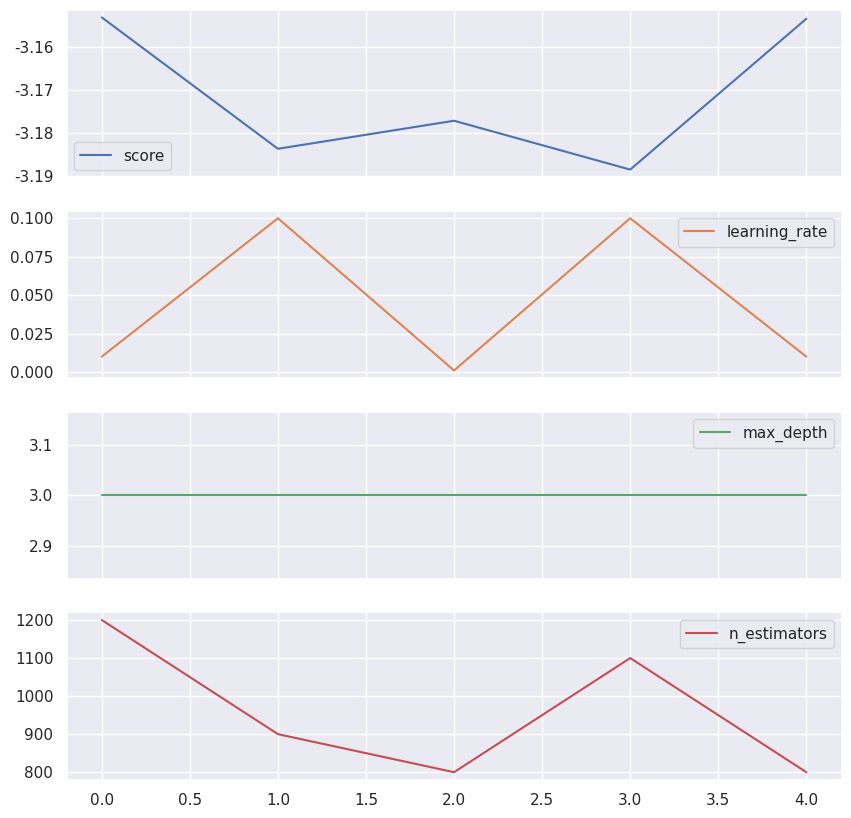

In [151]:
xgb_results_df=pd.DataFrame(np.transpose([xgb_rst.cv_results_['mean_test_score'],
                                         xgb_rst.cv_results_['param_learning_rate'].data,
                                         xgb_rst.cv_results_['param_max_depth'].data,
                                         xgb_rst.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
xgb_results_df.plot(subplots=True,figsize=(10, 10))

In [152]:
xgb_best_params['random_state'] = 42
xgb_best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
xgb_best_model = XGBRegressor(**xgb_best_params)

In [153]:
# n_iter = 0
# accuracy_lst = []

# for train_index, valid_index in skf.split(train_features, train_target):
#   n_iter += 1
#   # 학습용, 검증용 데이터 구성
#   train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
#   train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

#   # 학습
#   xgb_best_model.fit(train_x, train_y)
#   valid_pred = xgb_best_model.predict(valid_x) # 예측값

#   # 평가
#   rmse = mean_squared_error(valid_y, valid_pred, squared=False)
#   rmse_lst.append(rmse)
#   print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

##Light GBM

LGBMClassifier Hyper Parameter

- 주요 파리미터
  - n_estimators : 모델에서 사용할 트리 갯수(학습시 생성할 트리 갯수)
  - learning_rate : 학습률
  - criterion : 분할 품질을 측정하는 기능 (default : gini)
  - max_depth : 트리의 최대 깊이
  - min_samples_split : 내부 노드를 분할하는데 필요한 최소 샘플 수 (default : 2)
  - min_samples_leaf : 리프 노드에 있어야 할 최소 샘플 수 (default : 1)
  - min_weight_fraction_leaf : min_sample_leaf와 같지만 가중치가 부여된 샘플 수에서의 비율
  - max_features : 각 노드에서 분할에 사용할 특징의 최대 수
  - max_leaf_nodes : 리프 노드의 최대수
  - min_impurity_decrease : 최소 불순도
  - min_impurity_split : 나무 성장을 멈추기 위한 임계치
  - bootstrap : 부트스트랩(중복허용 샘플링) 사용 여부

In [154]:
from lightgbm import LGBMRegressor, plot_importance # 모델
from sklearn.metrics import mean_squared_error      # 평가지표 MSE

### model0

In [155]:
seed_everything(42)
hp= {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',  # 회귀 모델의 성능 측정 메트릭 (Root Mean Squared Error)
    'verbose' : -1
}

In [156]:
light_model = LGBMRegressor(**hp)
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(3,12,1,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
light_rst=RandomizedSearchCV(light_model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=3)
# 학습 (best hp 조합 찾기)
light_rst.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
light_rst.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


Fitting 6 folds for each of 5 candidates, totalling 30 fits


-3.1528611036680974

In [157]:
light_best_params = light_rst.best_params_
light_best_params

{'n_estimators': 1200, 'max_depth': 3, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

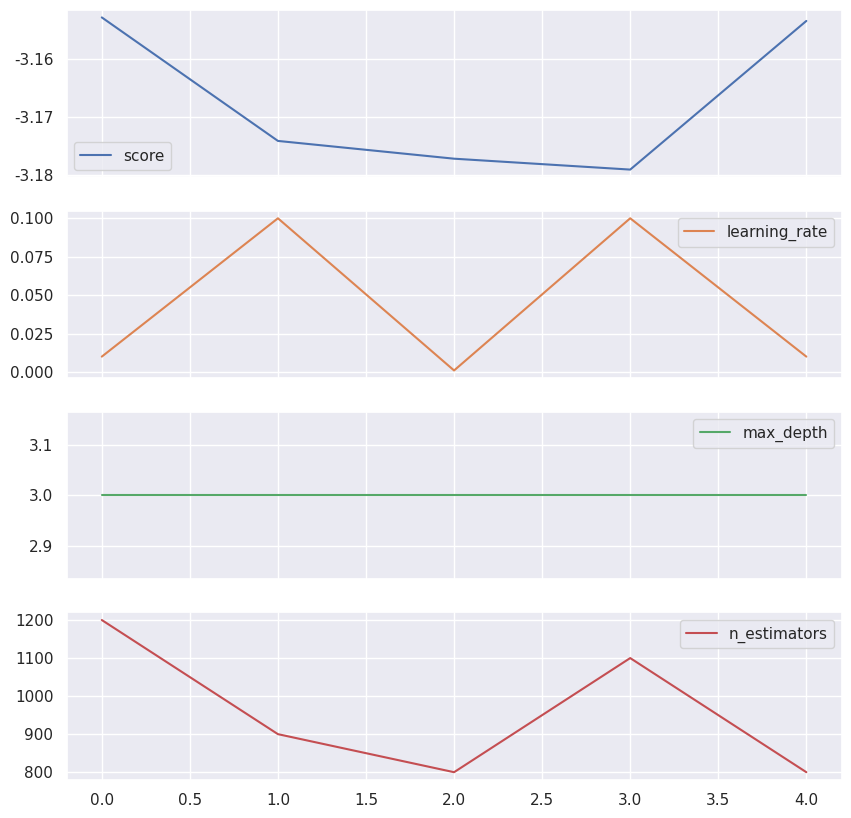

In [158]:
light_results_df=pd.DataFrame(np.transpose([light_rst.cv_results_['mean_test_score'],
                                         light_rst.cv_results_['param_learning_rate'].data,
                                         light_rst.cv_results_['param_max_depth'].data,
                                         light_rst.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
light_results_df.plot(subplots=True,figsize=(10, 10))

In [159]:
light_best_params['random_state'] = 42
light_best_params['verbose'] = -1
light_best_params['objective'] = 'regression'
light_best_params['boosting_type'] = 'gbdt'
light_best_params['metric'] = 'rmse'  # 회귀 모델의 성능 측정 메트릭 (Root Mean Squared Error)

# best 모델 인스턴스 생성(정의)
light_best_model = LGBMRegressor(**light_best_params)

In [160]:
# n_iter = 0
# accuracy_lst = []

# for train_index, valid_index in skf.split(train_features, train_target):
#   n_iter += 1
#   # 학습용, 검증용 데이터 구성
#   train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
#   train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

#   # 학습
#   light_best_model.fit(train_x, train_y)
#   valid_pred = light_best_model.predict(valid_x) # 예측값

#   # 평가
#   rmse = mean_squared_error(valid_y, valid_pred, squared=False)
#   rmse_lst.append(rmse)
#   print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

## Catboost

In [161]:
!pip install catboost

In [162]:
from catboost import CatBoostRegressor

In [163]:
# hp = {
#     "random_state" : 42,
#     "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
# }
# cat_model1 = CatBoostRegressor(**hp)
# n_iter = 0
# accuracy_lst = []

# for train_index, valid_index in skf.split(train_features, train_target):
#   n_iter += 1
#   # 학습용, 검증용 데이터 구성
#   train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
#   train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

#   # 학습
#   cat_model1.fit(train_x, train_y)
#   valid_pred = cat_model1.predict(valid_x) # 예측값

#   # 평가
#   rmse = mean_squared_error(valid_y, valid_pred, squared=False)
#   rmse_lst.append(rmse)
#   print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

### model 2

In [164]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
cat_hp_model = CatBoostRegressor(**hp)

In [165]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(3,12,1,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
cat_rst=RandomizedSearchCV(cat_hp_model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
cat_rst.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
cat_rst.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


-3.154866315406165

In [166]:
cat_best_params = cat_rst.best_params_
cat_best_params

{'n_estimators': 1200, 'max_depth': 3, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

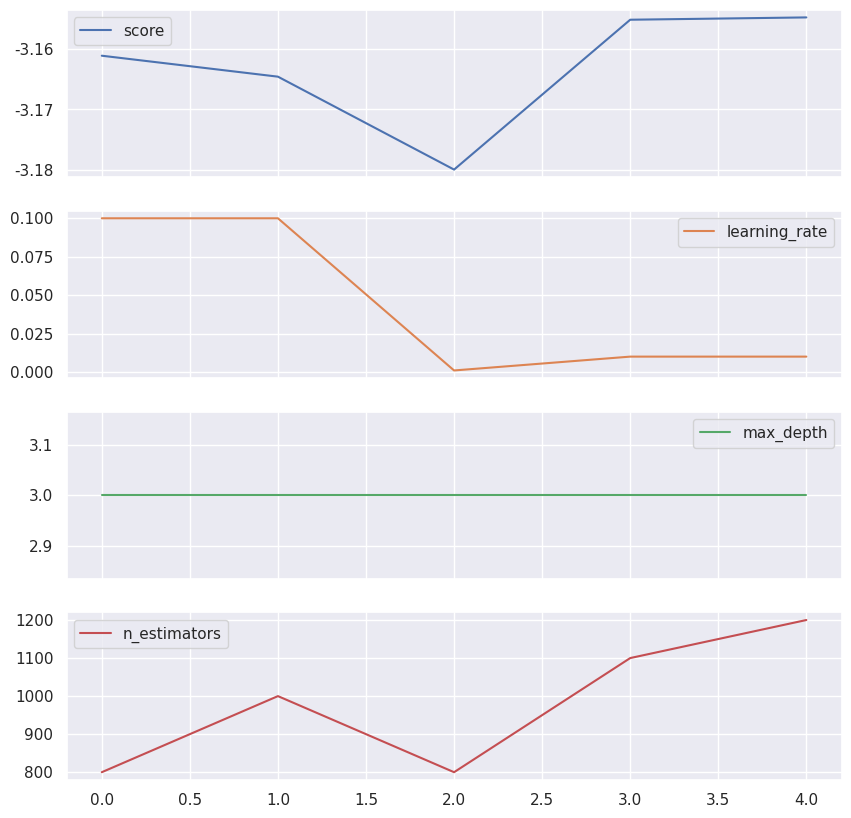

In [167]:
cat_results_df=pd.DataFrame(np.transpose([cat_rst.cv_results_['mean_test_score'],
                                         cat_rst.cv_results_['param_learning_rate'].data,
                                         cat_rst.cv_results_['param_max_depth'].data,
                                         cat_rst.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
cat_results_df.plot(subplots=True,figsize=(10, 10))

In [168]:
cat_best_params['random_state'] = 42
cat_best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
cat_best_model = CatBoostRegressor(**cat_best_params)

In [169]:
# n_iter = 0
# accuracy_lst = []

# for train_index, valid_index in skf.split(train_features, train_target):
#   n_iter += 1
#   # 학습용, 검증용 데이터 구성
#   train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
#   train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

#   # 학습
#   cat_best_model.fit(train_x, train_y)
#   valid_pred = cat_best_model.predict(valid_x) # 예측값

#   # 평가
#   rmse = mean_squared_error(valid_y, valid_pred, squared=False)
#   rmse_lst.append(rmse)
#   print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

In [170]:
# feature_importance = cat_best_model.feature_importances_
# sorted_idx = np.argsort(feature_importance)

# fig = plt.figure(figsize=(12, 6))
# plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# # plt.yticks(range(len(sorted_idx)), np.array(range(len(train_x)))[sorted_idx])
# # 변수명이 있다면, 아래와 같이...
# plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
# plt.title('Feature Importance')

## RandomForest

In [171]:
from sklearn.ensemble import RandomForestRegressor # 모델

### model1

In [172]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
rand_model = RandomForestRegressor(**hp)

In [173]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(3,12,1,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
}

# HPO 인스턴스 생성
rand_rst = RandomizedSearchCV(RandomForestRegressor(), hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=3)
# 학습 (best hp 조합 찾기)
rand_rst.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
rand_rst.best_score_

Fitting 6 folds for each of 5 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


-3.1697120541302777

In [174]:
rand_best_params = rand_rst.best_params_
rand_best_params

{'n_estimators': 800, 'max_depth': 3}

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

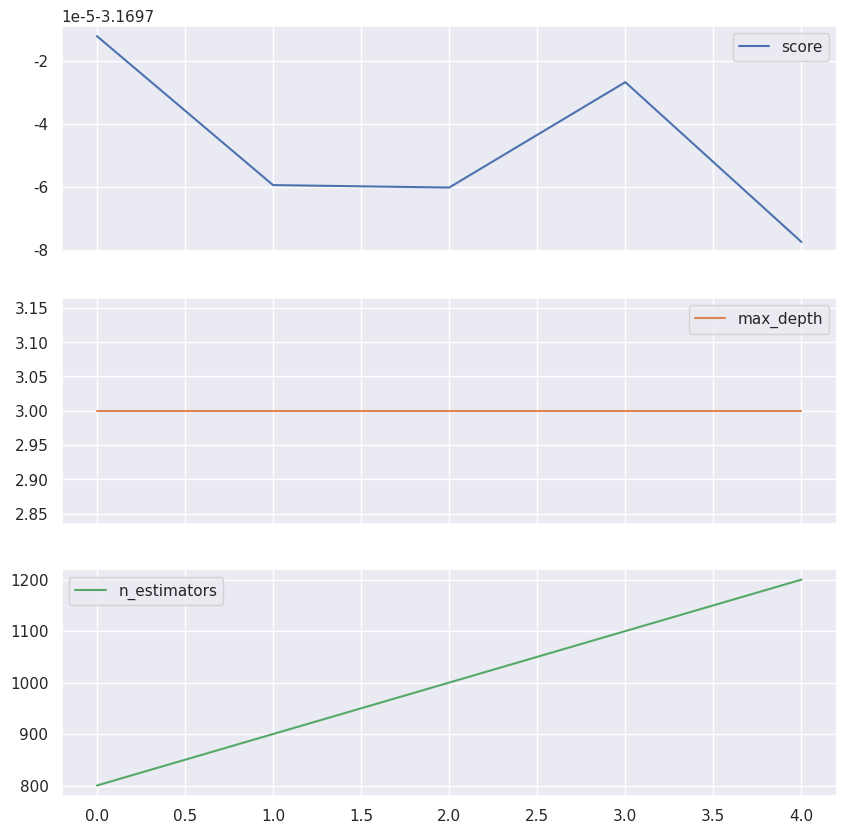

In [175]:
rand_results_df=pd.DataFrame(np.transpose([rand_rst.cv_results_['mean_test_score'],
                                         rand_rst.cv_results_['param_max_depth'].data,
                                         rand_rst.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'max_depth', 'n_estimators'])
rand_results_df.plot(subplots=True,figsize=(10, 10))

In [176]:
rand_best_params['random_state'] = 42
rand_best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
rand_best_model = RandomForestRegressor(**rand_best_params)

In [177]:
# n_iter = 0
# accuracy_lst = []

# for train_index, valid_index in skf.split(train_features, train_target):
#   n_iter += 1
#   # 학습용, 검증용 데이터 구성
#   train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
#   train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

#   # 학습
#   model.fit(train_x, train_y)
#   valid_pred = model.predict(valid_x) # 예측값

#   # 평가
#   rmse = mean_squared_error(valid_y, valid_pred, squared=False)
#   rmse_lst.append(rmse)
#   print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

## Voting

In [178]:
from sklearn.ensemble import VotingRegressor

In [179]:
seed_everything(42)
vote_model = VotingRegressor(
    estimators =[("xgb",xgb_best_model),
                 ("light", light_best_model),
                 ("cat", cat_best_model),
                 ("randforest", rand_best_model)]
)

- kFold

In [180]:
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # Voting Regressor 학습
    vote_model.fit(train_x, train_y)

    # 검증 데이터에 대한 예측
    valid_pred = vote_model.predict(valid_x)

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:42:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


1 번째 Stratified K-Fold RMSE: 3.165490825791001


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:42:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


2 번째 Stratified K-Fold RMSE: 3.1189564735010156


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:43:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


3 번째 Stratified K-Fold RMSE: 3.153428367504369


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:43:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


4 번째 Stratified K-Fold RMSE: 3.1285539990121687


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:44:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


5 번째 Stratified K-Fold RMSE: 3.193237790057636


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:45:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


6 번째 Stratified K-Fold RMSE: 3.1668706650204914
--------------------------------------------------
교차 검증 RMSE: 3.1544230201477803


In [181]:
vote_model

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          n_estimators=1200, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('light',
                             LGBMRegressor(learning_rate=0.01, max_depth=3,
                                           metric='rmse', n_estimators=1200,
                                           objective='regression',
                                           random_state=42, verbose=-1)),
                            ('cat',
                             <catboost.core.CatBoostRegressor object at 0x79b20b75f730>),
                            ('randforest',
                             RandomForestRegressor(max_depth=3,
                                                   n_estimators=800,
                                                   random_state=42))])

In [182]:
pred = vote_model.predict(train_features)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_target, pred))
print(f'RMSE: {rmse}')

RMSE: 3.135944899518951


## train_y, pred RMSE

In [183]:
pred_df = pd.DataFrame(pred, columns=['ECLO'])

# 평가

## 산포도

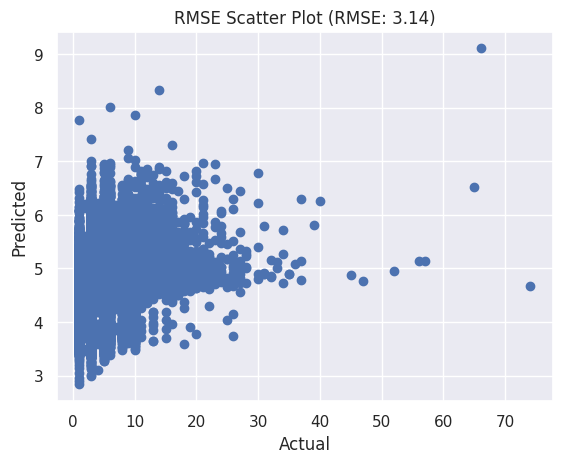

In [184]:
import matplotlib.pyplot as plt

# train_y와 pred의 RMSE를 계산
rmse = np.sqrt(mean_squared_error(train_target, pred))

# 산포도 그래프 생성
plt.scatter(train_target, pred)

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'RMSE Scatter Plot (RMSE: {rmse:.2f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 그래프 표시
plt.show()

# 제출

In [185]:
prediction =  vote_model.predict(test_features)

In [186]:
# Data를 불러와 DataFrame화
sample_submission = pd.read_csv(args.default_submission_path)

In [187]:
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = prediction
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.429639
1,ACCIDENT_39610,4.020162
2,ACCIDENT_39611,6.107629
3,ACCIDENT_39612,5.319876
4,ACCIDENT_39613,4.983438
...,...,...
10958,ACCIDENT_50567,5.699016
10959,ACCIDENT_50568,4.991525
10960,ACCIDENT_50569,5.053160
10961,ACCIDENT_50570,4.968357


In [188]:
from datetime import datetime, timedelta

In [189]:
now = datetime.now() + timedelta(hours=9)
formatted_time = now.strftime("%Y%m%d_%H%M")
formatted_time

'20231209_2045'

In [190]:
save_path = args.result_path + 'ver4_' + formatted_time + '.csv'
baseline_submission.to_csv(save_path, index=False)